In [1]:
import geopandas as gpd
import datetime
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation

In [3]:
eans = gpd.read_file('../data/eans_densified_streamlines/eans_flowlines_densified.shp')
eans = eans.to_crs("EPSG:4326")
eans # SplitID is not unique but GridID [or HydroID] is 

,arcid,GridID,OrigLength,SplitID,HydroID,From_Node,To_Node,NextDownID,PU_order,unique_ID,NEAr_reach,DrainID,Shape_Leng,geometry
0,2,589,2409.902812,561,589,1,2,591,2,1,2366104,646,2409.902812,"LINESTRING (-97.82719 30.2895, -97.82718 30.28..."
1,3,590,949.958982,562,590,3,1,589,1,2,2345196,647,949.958982,"LINESTRING (-97.8279 30.28856, -97.82791 30.28..."
2,4,591,1456.236724,563,591,2,4,594,4,3,2333479,648,1456.236724,"LINESTRING (-97.82169 30.29003, -97.82168 30.2..."
3,5,592,791.367099,564,592,5,6,611,1,4,2350042,649,791.367099,"LINESTRING (-97.81706 30.28912, -97.81706 30.2..."
4,6,593,926.054436,565,593,7,1,589,1,5,2345196,650,926.054436,"LINESTRING (-97.82672 30.28759, -97.82672 30.2..."
5,7,594,1369.366666,566,594,4,6,611,5,6,2350042,651,1369.366666,"LINESTRING (-97.82002 30.28785, -97.82 30.2878..."
6,8,595,2557.510460,567,595,8,4,594,1,7,2333479,652,2557.510460,"LINESTRING (-97.82624 30.28624, -97.82624 30.2..."
7,11,596,1472.047906,570,596,9,10,598,8,8,2381023,653,1472.047906,"LINESTRING (-97.81199 30.28005, -97.81199 30.2..."
8,12,597,2312.357177,571,597,11,12,601,1,9,2367560,654,2312.357177,"LINESTRING (-97.80762 30.27952, -97.80762 30.2..."
9,13,598,2192.353606,572,598,10,12,601,9,10,2367560,655,2192.353606,"LINESTRING (-97.81068 30.27714, -97.81067 30.2..."


In [5]:
assert (eans['GridID'] == eans['HydroID']).all()

In [6]:
eans['reach_ids'] = eans['HydroID'].astype('str')
eans['dx'] = eans['Shape_Leng']*0.3048
eans['K'] = eans['dx'] / 2.12
eans['X'] = [0.25 for i in range(eans['reach_ids'].size)]
eans['o_t'] = [0 for i in range(eans['reach_ids'].size)]
eans ['startnodes'] = [i for i in range(eans['reach_ids'].size)]

# $\Delta$T

In [7]:
print(f'Using the mean K, \u0394T must be less than {(2*eans['K'].values.mean()*(1-0.25)).item()} seconds')
print(f'Using the min K, \u0394T must be less than {(2*eans['K'].values.min()*(1-0.25)).item()} seconds')
print(f'Using the max K, \u0394T must be less than {(2*eans['K'].values.max()*(1-0.25)).item()} seconds')

Using the mean K, ΔT must be less than 433.18433148520234 seconds
Using the min K, ΔT must be less than 77.38661446906075 seconds
Using the max K, ΔT must be less than 643.7942088908603 seconds


In [8]:
eans

,arcid,GridID,OrigLength,SplitID,HydroID,From_Node,To_Node,NextDownID,PU_order,unique_ID,NEAr_reach,DrainID,Shape_Leng,geometry,reach_ids,dx,K,X,o_t,startnodes
0,2,589,2409.902812,561,589,1,2,591,2,1,2366104,646,2409.902812,"LINESTRING (-97.82719 30.2895, -97.82718 30.28...",589,734.538377,346.480367,0.25,0,0
1,3,590,949.958982,562,590,3,1,589,1,2,2345196,647,949.958982,"LINESTRING (-97.8279 30.28856, -97.82791 30.28...",590,289.547498,136.579008,0.25,0,1
2,4,591,1456.236724,563,591,2,4,594,4,3,2333479,648,1456.236724,"LINESTRING (-97.82169 30.29003, -97.82168 30.2...",591,443.860953,209.368374,0.25,0,2
3,5,592,791.367099,564,592,5,6,611,1,4,2350042,649,791.367099,"LINESTRING (-97.81706 30.28912, -97.81706 30.2...",592,241.208692,113.777685,0.25,0,3
4,6,593,926.054436,565,593,7,1,589,1,5,2345196,650,926.054436,"LINESTRING (-97.82672 30.28759, -97.82672 30.2...",593,282.261392,133.142166,0.25,0,4
5,7,594,1369.366666,566,594,4,6,611,5,6,2350042,651,1369.366666,"LINESTRING (-97.82002 30.28785, -97.82 30.2878...",594,417.382960,196.878755,0.25,0,5
6,8,595,2557.510460,567,595,8,4,594,1,7,2333479,652,2557.510460,"LINESTRING (-97.82624 30.28624, -97.82624 30.2...",595,779.529188,367.702447,0.25,0,6
7,11,596,1472.047906,570,596,9,10,598,8,8,2381023,653,1472.047906,"LINESTRING (-97.81199 30.28005, -97.81199 30.2...",596,448.680202,211.641605,0.25,0,7
8,12,597,2312.357177,571,597,11,12,601,1,9,2367560,654,2312.357177,"LINESTRING (-97.80762 30.27952, -97.80762 30.2...",597,704.806468,332.455881,0.25,0,8
9,13,598,2192.353606,572,598,10,12,601,9,10,2367560,655,2192.353606,"LINESTRING (-97.81068 30.27714, -97.81067 30.2...",598,668.229379,315.202537,0.25,0,9


In [9]:
endnodes = []
for i,v in enumerate(eans['NextDownID'].values):
    if v in eans['HydroID'].values:
        index = eans[eans['HydroID']== v].index[0]
        endnodes.append(eans ['startnodes'][index].item())
    else:
        endnodes.append(eans ['startnodes'][i].item())

In [10]:
eans['endnodes'] = endnodes

In [11]:
eans.columns

Index(['arcid', 'GridID', 'OrigLength', 'SplitID', 'HydroID', 'From_Node',
       'To_Node', 'NextDownID', 'PU_order', 'unique_ID', 'NEAr_reach',
       'DrainID', 'Shape_Leng', 'geometry', 'reach_ids', 'dx', 'K', 'X', 'o_t',
       'startnodes', 'endnodes'],
      dtype='object')

In [13]:
eans[['HydroID','NextDownID', 'startnodes', 'endnodes']]

,HydroID,NextDownID,startnodes,endnodes
0,589,591,0,2
1,590,589,1,0
2,591,594,2,5
3,592,611,3,22
4,593,589,4,0
5,594,611,5,22
6,595,594,6,5
7,596,598,7,9
8,597,601,8,12
9,598,601,9,12


In [14]:
print(eans.crs)
eans['geometry']

EPSG:4326


0     LINESTRING (-97.82719 30.2895, -97.82718 30.28...
1     LINESTRING (-97.8279 30.28856, -97.82791 30.28...
2     LINESTRING (-97.82169 30.29003, -97.82168 30.2...
3     LINESTRING (-97.81706 30.28912, -97.81706 30.2...
4     LINESTRING (-97.82672 30.28759, -97.82672 30.2...
5     LINESTRING (-97.82002 30.28785, -97.82 30.2878...
6     LINESTRING (-97.82624 30.28624, -97.82624 30.2...
7     LINESTRING (-97.81199 30.28005, -97.81199 30.2...
8     LINESTRING (-97.80762 30.27952, -97.80762 30.2...
9     LINESTRING (-97.81068 30.27714, -97.81067 30.2...
10    LINESTRING (-97.7989 30.2736, -97.7989 30.2736...
11    LINESTRING (-97.79753 30.27349, -97.79752 30.2...
12    LINESTRING (-97.8075 30.27567, -97.8075 30.275...
13    LINESTRING (-97.79334 30.26989, -97.79334 30.2...
14    LINESTRING (-97.79494 30.26868, -97.79493 30.2...
15    LINESTRING (-97.78886 30.26801, -97.78886 30.2...
16    LINESTRING (-97.80489 30.27031, -97.80489 30.2...
17    LINESTRING (-97.80329 30.26644, -97.80329 

In [15]:
paths = []

for line in eans['geometry']:
    coords = list(line.coords)  # Extract list of (x, y) tuples
    path = [[x, y] for x, y in coords]  # Convert to nested list
    paths.append([path])  # Match the structure: paths[i][0][j] = [x, y]

# Now wrap in a dict if you want to export to JSON
paths_json = {"paths": paths}


In [16]:
eans_dict = {
    'reach_ids': eans['reach_ids'].to_list(),
    'startnodes': eans['startnodes'].to_list(),
    'endnodes': eans['endnodes'].to_list(),
    'K': eans['K'].to_list(),
    'X': eans['X'].to_list(),
    'o_t': eans['o_t'].to_list(),
    'dx': eans['dx'].to_list(),
    'paths': paths,
}


In [17]:
eans_dict['datetime'] = '2024-12-31T23:58:00+00:00'
eans_dict['timedelta'] = 'P0DT0H1M0S'
eans_dict['name'] = "SHL_WAL"
eans_dict = {'model': eans_dict}
eans_dict['sinks'] = []
eans_dict['sources'] = []
eans_dict = {"SHL_WAL": eans_dict}
eans_dict = {'models': eans_dict}
eans_dict['connections'] = {}
eans_dict.keys()

dict_keys(['models', 'connections'])

In [18]:
with open('../data/eans_less_densified.json', 'w') as f:
    json.dump(eans_dict, f, indent=2)

In [19]:
# Define model file input path
input_path = '../data/eans_less_densified.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Eans')

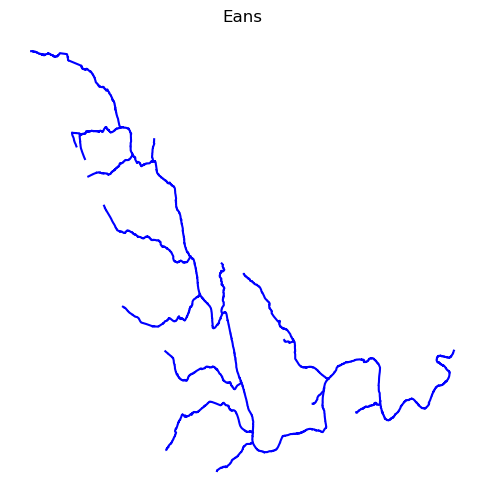

In [20]:
# Shoal creek and waller creek
fig, ax = plt.subplots(figsize=(6,6))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c='b')
plt.axis('off')
plt.title('Eans')

# 

# 